In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152, vit_l_16
from torchvision import io
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm
import csv

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.AutoAugment(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
}

full_dataset = datasets.ImageFolder("./train/")
print(full_dataset)

train_idx, val_idx = train_test_split(list(range(len(full_dataset))), test_size=0.2)
my_datasets = {}
my_datasets['train'] = Subset(full_dataset, train_idx)
my_datasets['val'] = Subset(full_dataset, val_idx)

class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

val_dataset = MyDataset(
    my_datasets['val'], transform=data_transforms['val']
)
train_dataset = MyDataset(
    my_datasets['train'], transform=data_transforms['train']
)

class_names = train_dataset.subset.dataset.classes

dataset_sizes = {'train': len(train_dataset),
                'val': len(val_dataset)}

# print(dataset_size)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using: {device}")

Dataset ImageFolder
    Number of datapoints: 1079
    Root location: ./train/
Using: cuda:0


In [16]:
# Initialize a dictionary to store the count of samples for each class
class_sample_count = {class_name: 0 for class_name in class_names}

# Count the number of samples for each class
for _, label in full_dataset:
    class_sample_count[class_names[label]] += 1

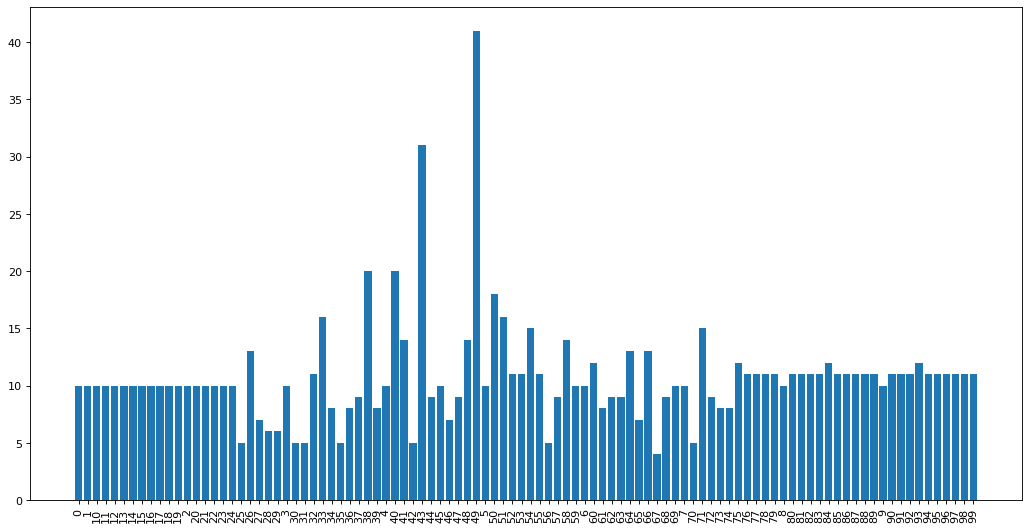

In [20]:
figure(figsize=(16, 8), dpi=80)

plt.bar(range(len(class_sample_count)), list(class_sample_count.values()), align='center')
plt.xticks(range(len(class_sample_count)), list(class_sample_count.keys()),rotation=90)

plt.show()

In [21]:
class_weights = []
for c in class_names:
    class_weights.append(1 - (class_sample_count[c]/1079))
class_weights = torch.tensor(class_weights).to(device)
class_weights

tensor([0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907,
        0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907, 0.9907,
        0.9954, 0.9880, 0.9935, 0.9944, 0.9944, 0.9907, 0.9954, 0.9954, 0.9898,
        0.9852, 0.9926, 0.9954, 0.9926, 0.9917, 0.9815, 0.9926, 0.9907, 0.9815,
        0.9870, 0.9954, 0.9713, 0.9917, 0.9907, 0.9935, 0.9917, 0.9870, 0.9620,
        0.9907, 0.9833, 0.9852, 0.9898, 0.9898, 0.9861, 0.9898, 0.9954, 0.9917,
        0.9870, 0.9907, 0.9907, 0.9889, 0.9926, 0.9917, 0.9917, 0.9880, 0.9935,
        0.9880, 0.9963, 0.9917, 0.9907, 0.9907, 0.9954, 0.9861, 0.9917, 0.9926,
        0.9926, 0.9889, 0.9898, 0.9898, 0.9898, 0.9898, 0.9907, 0.9898, 0.9898,
        0.9898, 0.9898, 0.9889, 0.9898, 0.9898, 0.9898, 0.9898, 0.9898, 0.9907,
        0.9898, 0.9898, 0.9898, 0.9889, 0.9898, 0.9898, 0.9898, 0.9898, 0.9898,
        0.9898], device='cuda:0')

In [22]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
              'val': DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)}

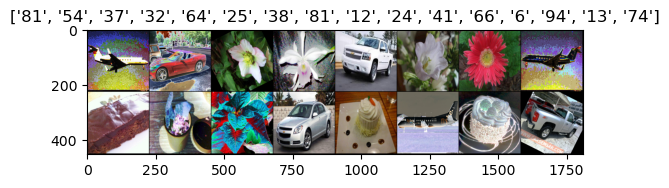

In [23]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# # Make a grid from batch
out = make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

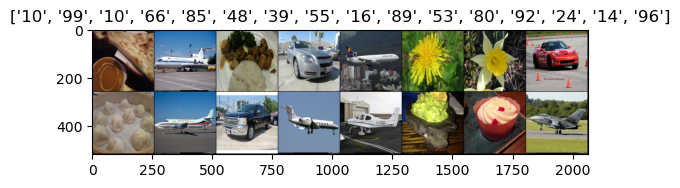

In [24]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                # if phase == 'train':
                #     scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [26]:
my_model =  resnet101(weights='IMAGENET1K_V2') # vit_l_16(weights='IMAGENET1K_V1') # resnet101(weights='IMAGENET1K_V2') #
# num_ftrs = my_model.heads.head.in_features
# my_model.heads.head = nn.Linear(num_ftrs, 100)
num_ftrs = my_model.fc.in_features
my_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 100)
)

my_model = my_model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

optimizer = optim.SGD(my_model.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-05)
# optimizer = optim.Adam(my_model.parameters(), lr=0.01, weight_decay=2e-05)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
tuned_model = train_model(my_model, 
                    criterion, 
                    optimizer,
                    scheduler,
                    num_epochs=20)

Epoch 0/19
----------


100%|██████████| 54/54 [00:05<00:00,  9.42it/s]


train Loss: 3.9267 Acc: 0.1321


100%|██████████| 14/14 [00:00<00:00, 18.44it/s]


val Loss: 3.0231 Acc: 0.3102

Epoch 1/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.65it/s]


train Loss: 2.4662 Acc: 0.4357


100%|██████████| 14/14 [00:00<00:00, 21.55it/s]


val Loss: 2.4735 Acc: 0.4028

Epoch 2/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.54it/s]


train Loss: 1.7558 Acc: 0.6756


100%|██████████| 14/14 [00:00<00:00, 21.20it/s]


val Loss: 2.2481 Acc: 0.4676

Epoch 3/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.77it/s]


train Loss: 1.3156 Acc: 0.8563


100%|██████████| 14/14 [00:00<00:00, 21.66it/s]


val Loss: 2.1080 Acc: 0.5417

Epoch 4/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.45it/s]


train Loss: 1.0863 Acc: 0.9386


100%|██████████| 14/14 [00:00<00:00, 18.15it/s]


val Loss: 2.0219 Acc: 0.6111

Epoch 5/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.61it/s]


train Loss: 1.0107 Acc: 0.9594


100%|██████████| 14/14 [00:00<00:00, 21.27it/s]


val Loss: 1.9661 Acc: 0.6296

Epoch 6/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.60it/s]


train Loss: 0.9538 Acc: 0.9791


100%|██████████| 14/14 [00:00<00:00, 20.10it/s]


val Loss: 1.9661 Acc: 0.6343

Epoch 7/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.48it/s]


train Loss: 0.9285 Acc: 0.9791


100%|██████████| 14/14 [00:00<00:00, 21.35it/s]


val Loss: 1.9517 Acc: 0.6343

Epoch 8/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.84it/s]


train Loss: 0.9039 Acc: 0.9884


100%|██████████| 14/14 [00:00<00:00, 19.41it/s]


val Loss: 2.0462 Acc: 0.6111

Epoch 9/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.80it/s]


train Loss: 0.8927 Acc: 0.9884


100%|██████████| 14/14 [00:00<00:00, 23.05it/s]


val Loss: 1.9364 Acc: 0.6389

Epoch 10/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.52it/s]


train Loss: 0.8647 Acc: 0.9965


100%|██████████| 14/14 [00:00<00:00, 21.34it/s]


val Loss: 1.9194 Acc: 0.6620

Epoch 11/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.62it/s]


train Loss: 0.8622 Acc: 0.9977


100%|██████████| 14/14 [00:00<00:00, 21.38it/s]


val Loss: 1.9129 Acc: 0.6852

Epoch 12/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.76it/s]


train Loss: 0.8665 Acc: 0.9930


100%|██████████| 14/14 [00:00<00:00, 19.94it/s]


val Loss: 1.9947 Acc: 0.6574

Epoch 13/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.37it/s]


train Loss: 0.8487 Acc: 0.9965


100%|██████████| 14/14 [00:00<00:00, 23.28it/s]


val Loss: 1.9739 Acc: 0.6667

Epoch 14/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.80it/s]


train Loss: 0.8369 Acc: 0.9988


100%|██████████| 14/14 [00:00<00:00, 15.68it/s]


val Loss: 2.0020 Acc: 0.6481

Epoch 15/19
----------


100%|██████████| 54/54 [00:04<00:00, 13.43it/s]


train Loss: 0.8416 Acc: 0.9942


100%|██████████| 14/14 [00:00<00:00, 17.89it/s]


val Loss: 1.9774 Acc: 0.6667

Epoch 16/19
----------


100%|██████████| 54/54 [00:03<00:00, 13.99it/s]


train Loss: 0.8358 Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 20.41it/s]


val Loss: 1.9655 Acc: 0.6898

Epoch 17/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.20it/s]


train Loss: 0.8339 Acc: 0.9977


100%|██████████| 14/14 [00:00<00:00, 21.30it/s]


val Loss: 1.9900 Acc: 0.6759

Epoch 18/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.40it/s]


train Loss: 0.8301 Acc: 0.9977


100%|██████████| 14/14 [00:00<00:00, 22.45it/s]


val Loss: 1.9933 Acc: 0.6528

Epoch 19/19
----------


100%|██████████| 54/54 [00:03<00:00, 14.88it/s]


train Loss: 0.8302 Acc: 0.9977


100%|██████████| 14/14 [00:00<00:00, 21.12it/s]


val Loss: 1.9755 Acc: 0.6806

Training complete in 1m 33s
Best val Acc: 0.689815


In [34]:
torch.save(tuned_model.state_dict(), "resnet101-v8")

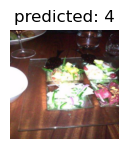

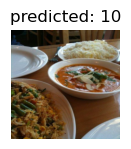

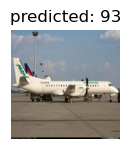

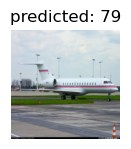

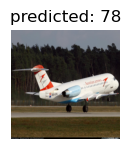

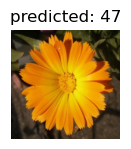

In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(tuned_model)

In [145]:
model_conv = resnet101(weights='IMAGENET1K_V2')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.SiLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 100)
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-05)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=50)

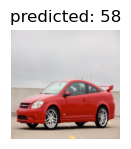

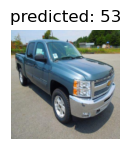

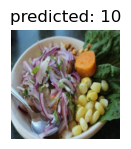

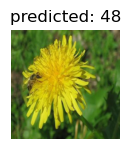

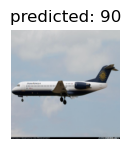

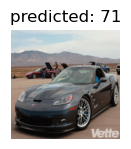

In [34]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [32]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [29]:
def predict(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        model.train(mode=was_training)
        return class_names[preds[0]]

In [30]:
with open('submissions/oliver-submission-resnet101-v8.csv', 'w', newline='') as csvfile:
    fieldnames = ['ID', 'Label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in tqdm(range(1036)):
        y = predict(tuned_model, f'test/{i}.jpg')
        writer.writerow({'ID': f'{i}.jpg', 'Label': y})

100%|██████████| 1036/1036 [01:15<00:00, 13.71it/s]


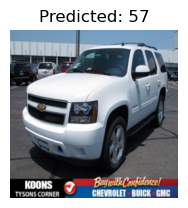

In [33]:
visualize_model_predictions(
    tuned_model,
    img_path='test/0.jpg'
)

plt.ioff()
plt.show()